In [1]:
from __future__ import division, print_function, unicode_literals
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.special import gammaln
from scipy.integrate import quad
import matplotlib.pyplot as plt
import seaborn as sns

from utils.metrics import (
    threshold_at_completeness_of,
    threshold_at_purity_of,
    bayes_conf
    )

plt.rc('legend', fontsize=10)

In [2]:
df = pd.read_csv("clens_test.csv")
y_fields = [
    'W1m0m4', 'W1m1m4', 'W1m2m4', 'W1m3m4', 'W1m4m4',
    'W1p1m4', 'W1p1p1', 'W1p2m4', 'W1p3m4', 'W1p3p1',
    'W1p4m4', 'W3m0m1', 'W3m2m1', 'W3m2p1', 'W3p2m3',
    'W4m1p1', 'W4m1p2', 'W4m1p3', 'W4m2p2', 'W4m2p3',
    'W4m3p3'
    ]
mag_i = df["MAG_i"].values
mask = (df["field"].isin(y_fields).values)
mag_i[mask] = df[mask]["MAG_y"].values

In [3]:
cnn_pred = np.load("clens_convnet_pred.npy")
y_true = np.load("clens_test_labels.npy")
print(cnn_pred.shape, cnn_pred.min(), cnn_pred.max())
print(y_true.shape, y_true.min(), y_true.max())

(15313,) 8.2989623141e-06 0.999963237234
(15313,) 0.0 1.0


In [4]:
phot_pred = np.loadtxt('clens_tpc.0.mlz', unpack=True, usecols=(2,))
morph_pred= np.loadtxt('clens_tpc.1.mlz', unpack=True, usecols=(2,))

In [5]:
mask = ((mag_i > -90) & (mag_i < 90))
mag_i, y_true, cnn_pred, phot_pred, morph_pred = map(
    lambda x: x[mask],
    [mag_i, y_true, cnn_pred, phot_pred, morph_pred]
)

In [6]:
def integrated_purity(y_true, y_pred, mag, bins=None, threshold=0.5, step=0.005, tol=0.001):

    low = np.zeros_like(bins)
    med = np.zeros_like(bins)
    high = np.zeros_like(bins)

    y_class = (y_pred >= threshold).astype(int)
    
    for i, b in enumerate(bins):
        mask = (mag < b)
        k = np.sum((y_true[mask] == 1) & (y_class[mask] == 1))
        N = np.sum(y_class[mask] == 1)
        med[i] = k / N
        low[i], high[i], _ = bayes_conf(N, k, step=step, tol=tol)
    
    return low, med, high

In [7]:
def integrated_completeness(y_true, y_pred, mag, bins=None, threshold=0.5, step=0.005, tol=0.001):

    low = np.zeros_like(bins)
    med = np.zeros_like(bins)
    high = np.zeros_like(bins)
    
    y_class = (y_pred >= threshold).astype(int)
    
    for i, b in enumerate(bins):
        mask = (mag < b)
        k = np.sum((y_true[mask] == 1) & (y_class[mask] == 1))
        N = np.sum(y_true[mask] == 1)
    
        if N > 0:
            med[i] = k / N
            low[i], high[i], _ = bayes_conf(N, k, step=step, tol=tol)
        else:
            low[i], med[i], high[i] = np.nan, np.nan, np.nan
            
    return low, med, high

In [27]:
bins = np.arange(19, 25.5, 0.5)

In [37]:
cnn_cut, _ = threshold_at_completeness_of(1 - y_true, 1 - cnn_pred, 0.96)

cnn_g_low, cnn_g_med, cnn_g_high = integrated_purity(
    1 - y_true, 1- cnn_pred,
    mag=mag_i, bins=bins, threshold=cnn_cut, step=0.001
    )

Done. N = 2194, k = 2192, area: 1.000, alpha: 0.9990, beta: 1.0000
Done. N = 2752, k = 2750, area: 1.000, alpha: 0.9990, beta: 1.0000
Done. N = 3553, k = 3549, area: 1.000, alpha: 0.9984, beta: 1.0000
Done. N = 3979, k = 3971, area: 0.683, alpha: 0.9970, beta: 0.9985
Done. N = 4700, k = 4691, area: 0.682, alpha: 0.9976, beta: 0.9990
Done. N = 6037, k = 6025, area: 0.683, alpha: 0.9974, beta: 0.9986
Done. N = 8061, k = 8041, area: 0.682, alpha: 0.9971, beta: 0.9988
Done. N = 10554, k = 10528, area: 0.684, alpha: 0.9970, beta: 0.9980
Done. N = 11436, k = 11406, area: 0.684, alpha: 0.9969, beta: 0.9979
Done. N = 12166, k = 12133, area: 0.683, alpha: 0.9969, beta: 0.9979
Done. N = 12643, k = 12609, area: 0.684, alpha: 0.9968, beta: 0.9977
Done. N = 12803, k = 12767, area: 0.683, alpha: 0.9967, beta: 0.9977
Done. N = 12844, k = 12808, area: 0.684, alpha: 0.9968, beta: 0.9977


In [29]:
morph_cut, _ = threshold_at_completeness_of(1 - y_true, 1 - morph_pred, 0.96)

morph_g_low, morph_g_med, morph_g_high = integrated_purity(
    1 - y_true, 1- morph_pred,
    mag=mag_i, bins=bins, threshold=morph_cut, step=0.001
    )

Done. N = 2190, k = 2188, area: 1.000, alpha: 0.9990, beta: 1.0000
Done. N = 2744, k = 2742, area: 1.000, alpha: 0.9990, beta: 1.0000
Done. N = 3522, k = 3518, area: 1.000, alpha: 0.9984, beta: 1.0000
Done. N = 3944, k = 3936, area: 0.682, alpha: 0.9973, beta: 0.9988
Done. N = 4654, k = 4644, area: 0.684, alpha: 0.9972, beta: 0.9986
Done. N = 5991, k = 5975, area: 0.683, alpha: 0.9967, beta: 0.9981
Done. N = 8025, k = 7997, area: 0.683, alpha: 0.9960, beta: 0.9980
Done. N = 10548, k = 10509, area: 0.683, alpha: 0.9957, beta: 0.9969
Done. N = 11445, k = 11404, area: 0.684, alpha: 0.9959, beta: 0.9970
Done. N = 12188, k = 12144, area: 0.683, alpha: 0.9959, beta: 0.9970
Done. N = 12671, k = 12624, area: 0.683, alpha: 0.9957, beta: 0.9968
Done. N = 12824, k = 12777, area: 0.682, alpha: 0.9958, beta: 0.9968
Done. N = 12858, k = 12811, area: 0.683, alpha: 0.9958, beta: 0.9969


In [30]:
phot_cut, _ = threshold_at_completeness_of(1 - y_true, 1 - phot_pred, 0.96)

phot_g_low, phot_g_med, phot_g_high = integrated_purity(
    1 - y_true, 1- phot_pred,
    mag=mag_i, bins=bins, threshold=phot_cut, step=0.001
    )

Done. N = 2093, k = 2084, area: 0.683, alpha: 0.9945, beta: 0.9976
Done. N = 2631, k = 2621, area: 0.684, alpha: 0.9951, beta: 0.9975
Done. N = 3406, k = 3394, area: 0.683, alpha: 0.9955, beta: 0.9975
Done. N = 3813, k = 3796, area: 0.683, alpha: 0.9946, beta: 0.9968
Done. N = 4526, k = 4505, area: 0.683, alpha: 0.9946, beta: 0.9967
Done. N = 5889, k = 5857, area: 0.683, alpha: 0.9939, beta: 0.9964
Done. N = 7961, k = 7910, area: 0.684, alpha: 0.9928, beta: 0.9946
Done. N = 10557, k = 10481, area: 0.683, alpha: 0.9921, beta: 0.9937
Done. N = 11464, k = 11382, area: 0.684, alpha: 0.9921, beta: 0.9937
Done. N = 12216, k = 12129, area: 0.684, alpha: 0.9922, beta: 0.9937
Done. N = 12702, k = 12609, area: 0.684, alpha: 0.9920, beta: 0.9936
Done. N = 12859, k = 12765, area: 0.683, alpha: 0.9919, beta: 0.9934
Done. N = 12901, k = 12807, area: 0.682, alpha: 0.9923, beta: 0.9943


In [31]:
cnn_cut, _ = threshold_at_purity_of(y_true, cnn_pred, 0.97)

cnn_s_low, cnn_s_med, cnn_s_high = integrated_completeness(
    y_true, cnn_pred,
    mag=mag_i, bins=bins, threshold=cnn_cut, step=0.001
    )

Done. N = 667, k = 655, area: 0.683, alpha: 0.9773, beta: 0.9879
Done. N = 880, k = 865, area: 0.682, alpha: 0.9779, beta: 0.9867
Done. N = 1092, k = 1069, area: 0.683, alpha: 0.9753, beta: 0.9843
Done. N = 1287, k = 1253, area: 0.682, alpha: 0.9690, beta: 0.9780
Done. N = 1483, k = 1440, area: 0.682, alpha: 0.9673, beta: 0.9763
Done. N = 1648, k = 1579, area: 0.683, alpha: 0.9536, beta: 0.9636
Done. N = 1778, k = 1668, area: 0.683, alpha: 0.9329, beta: 0.9444
Done. N = 1901, k = 1736, area: 0.684, alpha: 0.9070, beta: 0.9200
Done. N = 1932, k = 1749, area: 0.683, alpha: 0.9000, beta: 0.9138
Done. N = 1943, k = 1751, area: 0.682, alpha: 0.8955, beta: 0.9094
Done. N = 1950, k = 1752, area: 0.683, alpha: 0.8926, beta: 0.9065
Done. N = 1953, k = 1752, area: 0.683, alpha: 0.8904, beta: 0.9042
Done. N = 1953, k = 1752, area: 0.683, alpha: 0.8904, beta: 0.9042


In [32]:
morph_cut, _ = threshold_at_purity_of(y_true, morph_pred, 0.97)

morph_s_low, morph_s_med, morph_s_high = integrated_completeness(
    y_true, morph_pred,
    mag=mag_i, bins=bins, threshold=morph_cut, step=0.001
    )

Done. N = 667, k = 661, area: 0.683, alpha: 0.9875, beta: 0.9952
Done. N = 880, k = 871, area: 0.682, alpha: 0.9865, beta: 0.9935
Done. N = 1092, k = 1077, area: 0.683, alpha: 0.9830, beta: 0.9903
Done. N = 1287, k = 1262, area: 0.684, alpha: 0.9771, beta: 0.9849
Done. N = 1483, k = 1452, area: 0.684, alpha: 0.9758, beta: 0.9834
Done. N = 1648, k = 1601, area: 0.683, alpha: 0.9676, beta: 0.9758
Done. N = 1778, k = 1704, area: 0.682, alpha: 0.9542, beta: 0.9639
Done. N = 1901, k = 1787, area: 0.683, alpha: 0.9350, beta: 0.9460
Done. N = 1932, k = 1806, area: 0.684, alpha: 0.9298, beta: 0.9412
Done. N = 1943, k = 1808, area: 0.684, alpha: 0.9256, beta: 0.9374
Done. N = 1950, k = 1809, area: 0.683, alpha: 0.9228, beta: 0.9349
Done. N = 1953, k = 1810, area: 0.683, alpha: 0.9208, beta: 0.9326
Done. N = 1953, k = 1810, area: 0.683, alpha: 0.9208, beta: 0.9326


In [33]:
phot_cut, _ = threshold_at_purity_of(y_true, phot_pred, 0.97)

phot_s_low, phot_s_med, phot_s_high = integrated_completeness(
    y_true, phot_pred,
    mag=mag_i, bins=bins, threshold=phot_cut, step=0.001
    )

Done. N = 667, k = 599, area: 0.683, alpha: 0.8868, beta: 0.9103
Done. N = 880, k = 797, area: 0.683, alpha: 0.8970, beta: 0.9170
Done. N = 1092, k = 987, area: 0.682, alpha: 0.8960, beta: 0.9141
Done. N = 1287, k = 1155, area: 0.683, alpha: 0.8904, beta: 0.9077
Done. N = 1483, k = 1316, area: 0.684, alpha: 0.8796, beta: 0.8961
Done. N = 1648, k = 1433, area: 0.683, alpha: 0.8614, beta: 0.8781
Done. N = 1778, k = 1509, area: 0.683, alpha: 0.8400, beta: 0.8570
Done. N = 1901, k = 1556, area: 0.683, alpha: 0.8110, beta: 0.8290
Done. N = 1932, k = 1568, area: 0.683, alpha: 0.8024, beta: 0.8202
Done. N = 1943, k = 1570, area: 0.682, alpha: 0.8000, beta: 0.8180
Done. N = 1950, k = 1571, area: 0.684, alpha: 0.7970, beta: 0.8150
Done. N = 1953, k = 1571, area: 0.682, alpha: 0.7960, beta: 0.8140
Done. N = 1953, k = 1571, area: 0.682, alpha: 0.7960, beta: 0.8140


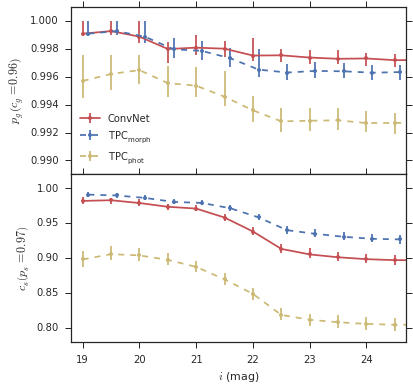

In [40]:
p = sns.color_palette()
sns.set_style("ticks")

fig = plt.figure(figsize=(6, 6))

ax0 = plt.subplot2grid((6, 3), (0, 0), colspan=3, rowspan=3)
ax1 = plt.subplot2grid((6, 3), (3, 0), colspan=3, rowspan=3)

plt.setp(ax0.get_xticklabels(), visible=False)

offset = 0.1

ax0.errorbar(
    bins, cnn_g_med,
    yerr=[cnn_g_med - cnn_g_low, cnn_g_high - cnn_g_med],
    label='ConvNet', ls='-', marker='o', markersize=4, color=p[2])

ax0.errorbar(
    bins + offset, morph_g_med,
    yerr=[morph_g_med - morph_g_low, morph_g_high - morph_g_med],
    label='$\mathregular{TPC_{morph}}$', ls='--', marker='o', markersize=4, color=p[0])

ax0.errorbar(
    bins, phot_g_med,
    yerr=[phot_g_med - phot_g_low, phot_g_high - phot_g_med],
    label='$\mathregular{TPC_{phot}}$', ls='--', marker='o', markersize=4, color=p[4])

ax0.set_xlim(18.8, 24.7)
ax0.set_ylim(0.989, 1.001)
ax0.set_yticks([0.990, 0.992, 0.994, 0.996, 0.998, 1.0])
ax0.set_ylabel(r'$p_g\left(c_g=0.96\right)$', fontsize=12)

ax0.legend(loc='lower left')

ax1.errorbar(
    bins, cnn_s_med,
    yerr=[cnn_s_med - cnn_s_low, cnn_s_high - cnn_s_med],
    label='ConvNet', ls='-', marker='o', markersize=4, color=p[2])

ax1.errorbar(
    bins + offset, morph_s_med,
    yerr=[morph_s_med - morph_s_low, morph_s_high - morph_s_med],
    label='$\mathregular{TPC_{morph}}$', ls='--', marker='o', markersize=4, color=p[0])

ax1.errorbar(
    bins, phot_s_med,
    yerr=[phot_s_med - phot_s_low, phot_s_high - phot_s_med],
    label='$\mathregular{TPC_{phot}}$', ls='--', marker='o', markersize=4, color=p[4])

ax1.set_ylabel(r'$c_s\left(p_s=0.97\right)$', fontsize=12)
ax1.set_xlim(18.8, 24.7)
ax1.set_ylim(0.78, 1.02)
#ax1.set_yticks([0.96, 0.97, 0.98, 0.99, 1.00])

ax1.set_xlabel(r'$i$ (mag)')

plt.subplots_adjust(hspace=0)

plt.savefig('figures/clens_integrated.pdf', bbox_inches='tight')

plt.show()